In [8]:
## Split Ticket (Best Thing without 538 https://split-ticket.org/2024-presidential-polling-averages/)

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/polling_dataset.csv", parse_dates=["end_date"])
df = df.sort_values("end_date")
df.head()

,end_date,dem_avg,rep_avg,margin
0,2024-07-21,44.0,47.1,-3.1
1,2024-07-22,43.7,46.6,-2.9
2,2024-07-23,43.8,46.2,-2.4
3,2024-07-24,44.1,46.0,-1.9
4,2024-07-25,44.2,45.7,-1.5


In [12]:
# Polling data (YYYY-MM-DD)
polls = pd.read_csv("data/polling_dataset.csv", parse_dates=["end_date"])

# Polymarket data (MM-DD-YYYY HH:MM UTC)
market = pd.read_csv("data/polymarket-price-data.csv", parse_dates=["Date (UTC)"]) #https://polymarket.com/event/presidential-election-winner-2024

polls = polls.rename(columns={"end_date": "date"})
market = market.rename(columns={"Date (UTC)": "date"})

polls["date"] = polls["date"].dt.floor("D")
market["date"] = market["date"].dt.floor("D")

polls = polls.sort_values("date")
market = market.sort_values("date")

merged = pd.merge_asof(
    polls,
    market,
    on="date",
    direction="backward"
)

output_path = "data/merged_polling_market.csv"
merged.to_csv(output_path, index=False)



Volatility Ratio (market / poll): 624.165
Mean Reversion Beta (poll): -0.069
Mean Reversion Beta (market): -0.133
Bias Persistence (rho) Poll: 0.994
Bias Persistence (rho) Market: 0.952
Bootstrap CI for Volatility Ratio: 240.174 - 1303.292


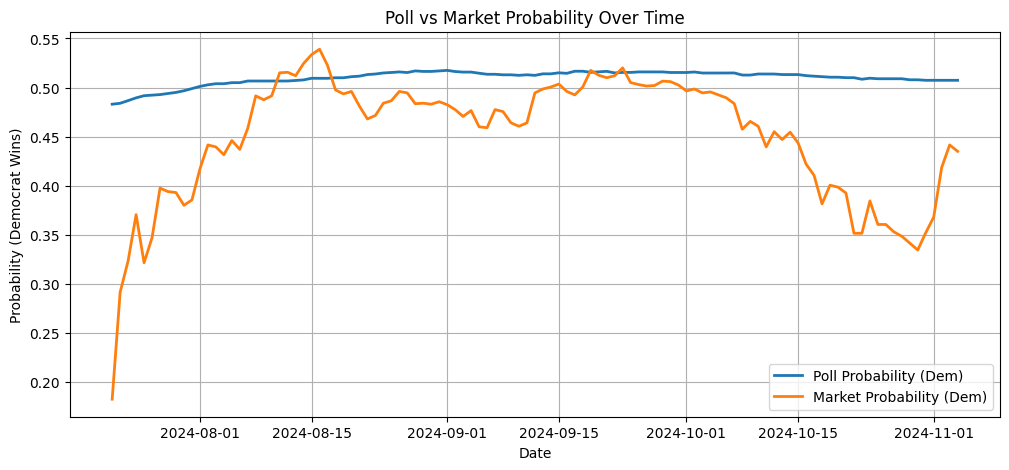

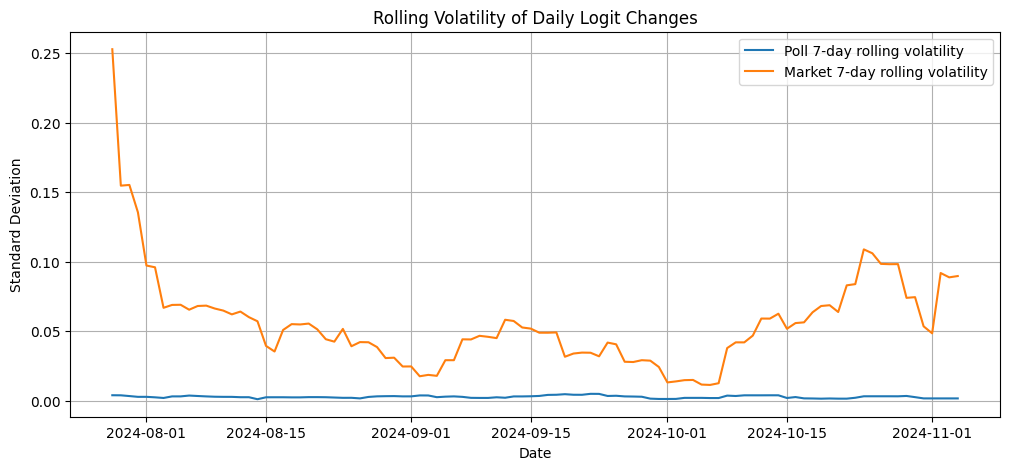

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
import matplotlib.pyplot as plt

df = pd.read_csv("data/merged_polling_market.csv", parse_dates=["date"])

# Convert polling averages to probabilities (Dem share of two-party)
df["poll_prob"] = df["dem_avg"] / (df["dem_avg"] + df["rep_avg"])

# Market probability is the Democratic side (Kamala Harris)
df["market_prob"] = df["Kamala Harris"]

# Convert to log odds
def logit(p):
    p = np.clip(p, 1e-6, 1 - 1e-6)
    return np.log(p / (1 - p))

df["poll_logit"] = logit(df["poll_prob"])
df["market_logit"] = logit(df["market_prob"])

# Daily changes (delta r_t)
df["poll_logit_change"] = df["poll_logit"].diff()
df["market_logit_change"] = df["market_logit"].diff()

# Volatility ratio
poll_var = np.var(df["poll_logit_change"].dropna())
market_var = np.var(df["market_logit_change"].dropna())
volatility_ratio = market_var / poll_var
print("Volatility Ratio (market / poll):", round(volatility_ratio, 3))

# Mean reversion regression
def mean_reversion_beta(series):
    p = series.dropna().to_numpy()
    mean_val = np.mean(p)
    dp = np.diff(p)
    x = p[:-1] - mean_val
    model = LinearRegression().fit(x.reshape(-1, 1), dp)
    beta = model.coef_[0]
    return beta

beta_poll = mean_reversion_beta(df["poll_prob"])
beta_market = mean_reversion_beta(df["market_prob"])

print("Mean Reversion Beta (poll):", round(beta_poll, 3))
print("Mean Reversion Beta (market):", round(beta_market, 3))

# Bias persistence (autocorrelation of bias)
# Assume Democrat (Kamala Harris) ultimately lost (2024 Election)
final_outcome = 0
df["poll_bias"] = df["poll_prob"] - final_outcome
df["market_bias"] = df["market_prob"] - final_outcome

def autocorr(series):
    s = series.dropna()
    return np.corrcoef(s[:-1], s[1:])[0, 1]

rho_poll = autocorr(df["poll_bias"])
rho_market = autocorr(df["market_bias"])

print("Bias Persistence (rho) Poll:", round(rho_poll, 3))
print("Bias Persistence (rho) Market:", round(rho_market, 3))

# Bootstrap confidence intervals for variance difference
n_boot = 1000
diffs = []
for i in range(n_boot):
    poll_sample = resample(df["poll_logit_change"].dropna())
    market_sample = resample(df["market_logit_change"].dropna())
    ratio = np.var(market_sample) / np.var(poll_sample)
    diffs.append(ratio)

ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
print("Bootstrap CI for Volatility Ratio:", round(ci_low, 3), "-", round(ci_high, 3))

# Summary
summary = pd.DataFrame({
    "metric": ["volatility_ratio", "mean_reversion_beta_poll", "mean_reversion_beta_market",
               "bias_rho_poll", "bias_rho_market"],
    "value": [volatility_ratio, beta_poll, beta_market, rho_poll, rho_market]
})
summary.to_csv("data/efficiency_summary.csv", index=False)

# Visualizations
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["poll_prob"], label="Poll Probability (Dem)", linewidth=2)
plt.plot(df["date"], df["market_prob"], label="Market Probability (Dem)", linewidth=2)
plt.legend()
plt.title("Poll vs Market Probability Over Time")
plt.xlabel("Date")
plt.ylabel("Probability (Democrat Wins)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["poll_logit_change"].rolling(7).std(), label="Poll 7-day rolling volatility")
plt.plot(df["date"], df["market_logit_change"].rolling(7).std(), label="Market 7-day rolling volatility")
plt.legend()
plt.title("Rolling Volatility of Daily Logit Changes")
plt.xlabel("Date")
plt.ylabel("Standard Deviation")
plt.grid(True)
plt.show()

In [14]:
# Major event dates within Aug-01 to Nov-04 2024
event_dates = [
    "2024-09-10",  # Presidential debate Harris-Trump
    "2024-10-01",  # Vice presidential debate
]
event_dates = pd.to_datetime(event_dates)

# Create a DataFrame for event windows (one week before to one week after)
windows = []
for ed in event_dates:
    for offset in range(-7, 8):  # 7 days before to 7 days after → total 15 days each
        windows.append({"event_date": ed, "window_date": ed + pd.Timedelta(days=offset)})
window_df = pd.DataFrame(windows)

# Merge with your main DataFrame to pick out those dates
df2 = df.copy()
df2["date"] = pd.to_datetime(df2["date"])
window_df = window_df.merge(df2, left_on="window_date", right_on="date", how="left")

# Compute shifts
results = []
for ed in event_dates:
    sub = window_df[window_df["event_date"] == ed].sort_values("window_date")
    # polling data
    poll_start = sub.iloc[0]["poll_prob"]
    poll_event = sub[sub["window_date"] == ed]["poll_prob"].iloc[0]
    poll_end   = sub.iloc[-1]["poll_prob"]
    # market data
    market_start = sub.iloc[0]["market_prob"]
    market_event = sub[sub["window_date"] == ed]["market_prob"].iloc[0]
    market_end   = sub.iloc[-1]["market_prob"]
    results.append({
        "event_date": ed,
        "poll_change_pre_to_event": poll_event - poll_start,
        "poll_change_event_to_post": poll_end - poll_event,
        "market_change_pre_to_event": market_event - market_start,
        "market_change_event_to_post": market_end - market_event
    })

results_df = pd.DataFrame(results)
results_df.to_csv("data/event_window_shifts.csv", index=False)

Paired t-test: Total Range Magnitude (Poll vs Market)
t-statistic: -7.619
p-value: 0.0
Wilcoxon test: 0.0 p-value: 0.0001
Average (Market - Poll) Range Difference: 0.0724


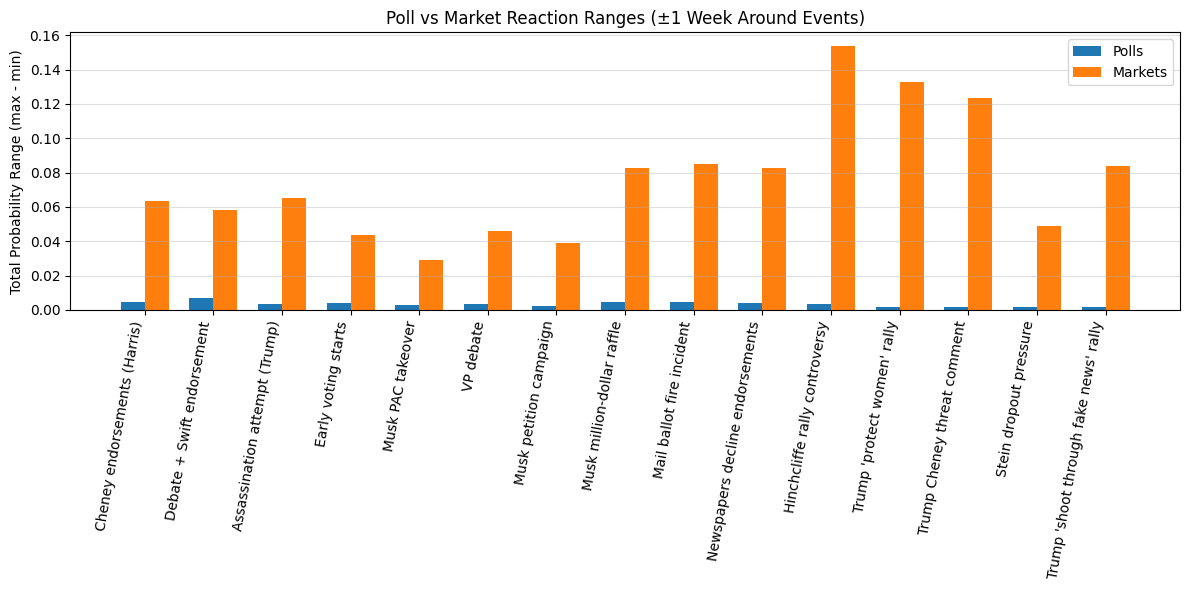

Event-by-Event Summary:
event_date                            event_name  poll_total_range  market_total_range  difference
2024-09-06          Cheney endorsements (Harris)          0.004444              0.0635    0.059056
2024-09-10            Debate + Swift endorsement          0.006977              0.0580    0.051023
2024-09-15         Assassination attempt (Trump)          0.003679              0.0650    0.061321
2024-09-20                   Early voting starts          0.004269              0.0435    0.039231
2024-09-26                     Musk PAC takeover          0.002732              0.0290    0.026268
2024-10-01                             VP debate          0.003716              0.0460    0.042284
2024-10-07                Musk petition campaign          0.002141              0.0390    0.036859
2024-10-10            Musk million-dollar raffle          0.004357              0.0825    0.078143
2024-10-24             Mail ballot fire incident          0.004691              0.085

In [22]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
import matplotlib.pyplot as plt

df = pd.read_csv("data/merged_polling_market.csv", parse_dates=["date"])
df = df.sort_values("date")

df["poll_prob"] = df["dem_avg"] / (df["dem_avg"] + df["rep_avg"])
df["market_prob"] = df["Kamala Harris"]

# Define Major 2024 Election Events
event_descriptions = {
    "2024-09-06": "Cheney endorsements (Harris)",
    "2024-09-10": "Debate + Swift endorsement",
    "2024-09-15": "Assassination attempt (Trump)",
    "2024-09-20": "Early voting starts",
    "2024-09-26": "Musk PAC takeover",
    "2024-10-01": "VP debate",
    "2024-10-07": "Musk petition campaign",
    "2024-10-10": "Musk million-dollar raffle",
    "2024-10-24": "Mail ballot fire incident",
    "2024-10-25": "Newspapers decline endorsements",
    "2024-10-27": "Hinchcliffe rally controversy",
    "2024-10-30": "Trump 'protect women' rally",
    "2024-10-31": "Trump Cheney threat comment",
    "2024-11-01": "Stein dropout pressure",
    "2024-11-03": "Trump 'shoot through fake news' rally"
}
event_dates = pd.to_datetime(list(event_descriptions.keys()))

# Compute max-min range before and after each event
results = []
for ed in event_dates:
    # +/- 7 day window
    pre_window = df[(df["date"] >= ed - pd.Timedelta(days=7)) & (df["date"] < ed)]
    post_window = df[(df["date"] > ed) & (df["date"] <= ed + pd.Timedelta(days=7))]

    # Skip if not enough data
    if pre_window.empty or post_window.empty:
        continue

    # Compute pre/post ranges for polls and markets
    poll_pre_range = pre_window["poll_prob"].max() - pre_window["poll_prob"].min()
    poll_post_range = post_window["poll_prob"].max() - post_window["poll_prob"].min()
    market_pre_range = pre_window["market_prob"].max() - pre_window["market_prob"].min()
    market_post_range = post_window["market_prob"].max() - post_window["market_prob"].min()

    results.append({
        "event_date": ed,
        "event_name": event_descriptions[ed.strftime("%Y-%m-%d")],
        "poll_pre_range": poll_pre_range,
        "poll_post_range": poll_post_range,
        "market_pre_range": market_pre_range,
        "market_post_range": market_post_range
    })

ranges = pd.DataFrame(results)
ranges["poll_total_range"] = ranges["poll_pre_range"] + ranges["poll_post_range"]
ranges["market_total_range"] = ranges["market_pre_range"] + ranges["market_post_range"]

# Stats
t_stat, p_val = ttest_rel(ranges["poll_total_range"], ranges["market_total_range"])
print("Paired t-test: Total Range Magnitude (Poll vs Market)")
print("t-statistic:", round(t_stat, 3))
print("p-value:", round(p_val, 4))

# Also test nonparametric version
try:
    w_stat, w_pval = wilcoxon(ranges["poll_total_range"], ranges["market_total_range"])
    print("Wilcoxon test:", round(w_stat, 3), "p-value:", round(w_pval, 4))
except ValueError:
    print("Wilcoxon test could not run (possible zero differences).")

# Compute mean difference
ranges["difference"] = ranges["market_total_range"] - ranges["poll_total_range"]
avg_diff = ranges["difference"].mean()
print("Average (Market - Poll) Range Difference:", round(avg_diff, 4))

# Visualization
plt.figure(figsize=(12, 6))
x = np.arange(len(ranges))
bar_width = 0.35

plt.bar(x - bar_width/2, ranges["poll_total_range"], width=bar_width, label="Polls")
plt.bar(x + bar_width/2, ranges["market_total_range"], width=bar_width, label="Markets")

plt.xticks(x, ranges["event_name"], rotation=80, ha="right")
plt.ylabel("Total Probability Range (max - min)")
plt.title("Poll vs Market Reaction Ranges (1 Week Around Events)")
plt.legend()
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()
plt.show()

# Summary Table
print("Event-by-Event Summary:")
display_cols = ["event_date", "event_name", "poll_total_range", "market_total_range", "difference"]
print(ranges[display_cols].to_string(index=False))

# Interpretation
if p_val < 0.05:
    print("Conclusion:")
    print("There is some evidence that polls and markets reacted differently around major campaign events (p < 0.05).")
    if avg_diff < 0:
        print("Polls showed larger swings, suggesting markets were more stable overall.")
    else:
        print("Markets showed larger swings, suggesting they were more sensitive to real-time news.")
else:
    print("Conclusion:")
    print("No statistically significant difference found between poll and market reactions to events.")


Volatility Ratio (market / poll): 624.165
Mean Reversion (poll): -0.069
Mean Reversion (market): -0.133
Bias Persistence poll: 0.994
Bias Persistence market: 0.952
Residual Variance (poll): 5e-05
Residual Variance (market): 0.00388
Levene Test for Equal Variances: stat = 46.967 p = 0.0


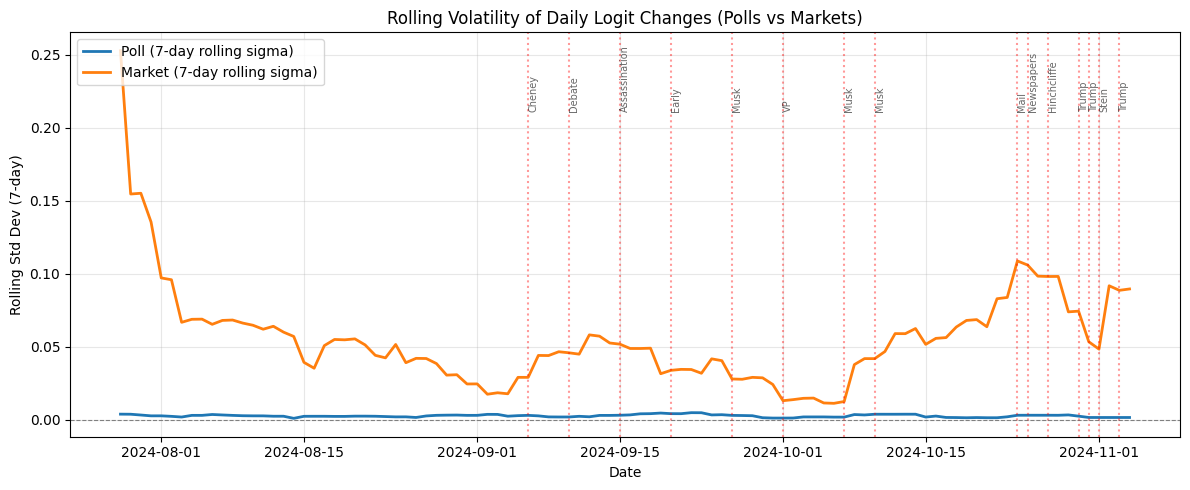

Interpretation:
- Markets were more erratic (higher volatility ratio).
- Market probabilities showed stronger mean reversion (less bias persistence).
- Market bias decayed faster than polling bias (more responsive).


In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import levene
import matplotlib.pyplot as plt

df = pd.read_csv("data/merged_polling_market.csv", parse_dates=["date"])
df = df.sort_values("date")

df["poll_prob"] = df["dem_avg"] / (df["dem_avg"] + df["rep_avg"])
df["market_prob"] = df["Kamala Harris"]

event_descriptions = {
    "2024-09-06": "Cheney endorsements (Harris)",
    "2024-09-10": "Debate + Swift endorsement",
    "2024-09-15": "Assassination attempt (Trump)",
    "2024-09-20": "Early voting starts",
    "2024-09-26": "Musk PAC takeover",
    "2024-10-01": "VP debate",
    "2024-10-07": "Musk petition campaign",
    "2024-10-10": "Musk million-dollar raffle",
    "2024-10-24": "Mail ballot fire incident",
    "2024-10-25": "Newspapers decline endorsements",
    "2024-10-27": "Hinchcliffe rally controversy",
    "2024-10-30": "Trump 'protect women' rally",
    "2024-10-31": "Trump Cheney threat comment",
    "2024-11-01": "Stein dropout pressure",
    "2024-11-03": "Trump 'shoot through fake news' rally"
}
event_dates = pd.to_datetime(list(event_descriptions.keys()))

# Logit Transform and Daily Changes
def logit(p):
    p = np.clip(p, 1e-6, 1 - 1e-6)
    return np.log(p / (1 - p))

df["poll_logit"] = logit(df["poll_prob"])
df["market_logit"] = logit(df["market_prob"])

df["poll_change"] = df["poll_logit"].diff()
df["market_change"] = df["market_logit"].diff()

# Volatility Ratio
poll_var = np.var(df["poll_change"].dropna())
market_var = np.var(df["market_change"].dropna())
volatility_ratio = market_var / poll_var
print("Volatility Ratio (market / poll):", round(volatility_ratio, 3))

# Mean Reversion
def mean_reversion_beta(series):
    p = series.dropna().to_numpy()
    dp = np.diff(p)
    x = p[:-1] - np.mean(p)
    model = LinearRegression().fit(x.reshape(-1, 1), dp)
    return model.coef_[0]

beta_poll = mean_reversion_beta(df["poll_prob"])
beta_market = mean_reversion_beta(df["market_prob"])
print("Mean Reversion (poll):", round(beta_poll, 3))
print("Mean Reversion (market):", round(beta_market, 3))

# Bias Persistence (autocorrelation of bias)
final_outcome = 1  # assume Harris wins
df["poll_bias"] = df["poll_prob"] - final_outcome
df["market_bias"] = df["market_prob"] - final_outcome

def autocorr(series):
    s = series.dropna()
    return np.corrcoef(s[:-1], s[1:])[0, 1]

rho_poll = autocorr(df["poll_bias"])
rho_market = autocorr(df["market_bias"])
print("Bias Persistence poll:", round(rho_poll, 3))
print("Bias Persistence market:", round(rho_market, 3))

# Event-Adjusted Residual Variance
df["event_dummy"] = df["date"].isin(event_dates).astype(int)

# Regress p_t on event indicators for both sources
def residual_variance(y, X):
    X = X.values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    preds = model.predict(X)
    residuals = y - preds
    return np.var(residuals)

poll_resid_var = residual_variance(df["poll_prob"].dropna(), df["event_dummy"].loc[df["poll_prob"].notna()])
market_resid_var = residual_variance(df["market_prob"].dropna(), df["event_dummy"].loc[df["market_prob"].notna()])

print("Residual Variance (poll):", round(poll_resid_var, 5))
print("Residual Variance (market):", round(market_resid_var, 5))

# Variance Equality Test (Levene)
stat, p_val = levene(df["poll_change"].dropna(), df["market_change"].dropna())
print("Levene Test for Equal Variances: stat =", round(stat, 3), "p =", round(p_val, 4))

# Combine Results
summary = pd.DataFrame({
    "Metric": [
        "Volatility Ratio (market / poll)",
        "Mean Reversion (poll)",
        "Mean Reversion (market)",
        "Bias Persistence (poll)",
        "Bias Persistence (market)",
        "Residual Variance (poll)",
        "Residual Variance (market)"
    ],
    "Value": [
        volatility_ratio, beta_poll, beta_market, rho_poll, rho_market, poll_resid_var, market_resid_var
    ]
})
summary.to_csv("data/efficiency_summary_extended.csv", index=False)

# Rolling Volatility Plot
plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["poll_change"].rolling(7).std(), label="Poll (7-day rolling sigma)", linewidth=2)
plt.plot(df["date"], df["market_change"].rolling(7).std(), label="Market (7-day rolling sigma)", linewidth=2)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Add Major Events
for ed, desc in event_descriptions.items():
    ed_dt = pd.to_datetime(ed)
    plt.axvline(ed_dt, color='red', linestyle=':', alpha=0.4)
    plt.text(ed_dt, plt.ylim()[1]*0.8, desc.split()[0], rotation=90, fontsize=7, alpha=0.6)

plt.title("Rolling Volatility of Daily Logit Changes (Polls vs Markets)")
plt.xlabel("Date")
plt.ylabel("Rolling Std Dev (7-day)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretation
print("Interpretation:")
if volatility_ratio < 1:
    print("- Markets exhibited smoother daily updates than polls (lower volatility).")
else:
    print("- Markets were more erratic (higher volatility ratio).")

if beta_market < beta_poll:
    print("- Market probabilities showed stronger mean reversion (less bias persistence).")

if rho_market < rho_poll:
    print("- Market bias decayed faster than polling bias (more responsive).")

if market_resid_var < poll_resid_var:
    print("- Markets had lower unexplained variance after accounting for events (less emotional noise).")